# Data Wrangling Open Streetmap Data

**Chris Madeley**

## Table of Contents

## Introduction

In [1]:
from __future__ import division, absolute_import

In [2]:
from data_cleaning import shape_element

In [3]:
import pandas as pd
from pymongo import MongoClient
import xml.etree.cElementTree as ET
import re

In [31]:
from numpy import nan
import numpy as np

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Parsing and Import

In [6]:
client = MongoClient()
db = client['udacity']
osm = db['osm_perth']

In [60]:
file_in = 'osm_data/perth.osm'

In [10]:
i = 0
data = []

print('Parsing Data')
for _, element in ET.iterparse(file_in):
    i += 1
    el = shape_element(element)
    if el:
        data.append(el)
#         osm_data.insert_one(el)
    if i%100000 == 0:
        print i,
    elif i%10000 == 0:
        print '.',

print('\n\nInserting Data into MongoDB')
print '\n',
osm.insert(data)
print('Done!')

Parsing Data
. . . . . . . . . 100000 . . . . . . . . . 200000 . . . . . . . . . 300000 . . . . . . . . . 400000 . . . . . . . . . 500000 . . . . . . . . . 600000 . . . . . . . . . 700000 . . . . . . . . . 800000 . . . . . . . . . 900000 . . . . . . . . . 1000000 . . . . . . . . . 1100000 . . . . . . . . . 1200000 . . . . . . . . . 1300000 . . . . . . . . . 1400000 . . . . . . . . . 1500000 . . . . . . . . . 1600000 . . . . . . . . . 1700000 . . . . . . . . . 1800000 . . . . . . . . . 1900000 . . . . 

Inserting Data into MongoDB

Done!


## Problems Encountered / Data Corrections

In [7]:
cursor = osm.aggregate([
        {'$match':{'address.street':{'$exists':1}}},
        {'$project':{'street_name': '$address.street',
                    'pos': '$pos'}}
    ])
streets_df = pd.DataFrame([_ for _ in cursor])

In [8]:
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

In [9]:
def street_extension(x):
    ans = street_type_re.findall(x)
    if len(ans) >= 1:
        return ans[0]
    else:
        return nan

In [10]:
streets_df['extension'] = streets_df.street_name.apply(street_extension)

In [11]:
expected = set(['Avenue', 'Boulevard', 'Circle', 'Close', 'Court', 'Cove',
                'Crescent', 'Drive', 'Garden', 'Gardens', 'Grove', 'Highway',
                'Lane', 'Loop', 'Mews', 'Pass', 'Parade', 'Place', 'Rise', 'Road', 'Street',
                'Terrace', 'Trail', 'Way', 'View'])

In [12]:
checked_names = set(['Burnby Cross', 'The Heights', 'Liddell Heights', 'The Grange', 'The Elbow',
                    'Talisker Gate', 'Kangaroo Entrance', 'The Elbow', 'Riverton Drive East',
                    'The Promenade', 'Brookside Square', 'The Ramble',
                    'Solway Green', 'Beechboro Road North'])

In [13]:
extension_fixes = {
    'Ave': 'Avenue',
    'Cres': 'Crescent',
    'Rd': 'Road',
    'Road,': 'Road',
    'CRT': 'Court',
    'Crt': 'Court',
    'Ct': 'Court',
    'Crs': 'Crescent',
    'Terriace': 'Terrace',
    'St':'Street',
    'gate': 'Gate',
    'Boulevarde': 'Boulevard', # misspelling
    }
name_fixes = {
    'Morrison' : 'Morrison Road',
    'Oxford': 'Oxford Street',
    'Beaufort': 'Beaufort Street',
    'Tarata Way W/ENT': 'Tarata Way',
    'Tarata Way E/ENT': 'Tarata Way',
    'Tarata Way E/Ent': 'Tarata Way',
    'Tarata Way SW Entrance': 'Tarata Way',
    'Tarata Way E/Ent': 'Tarata Way',
    'Tarata Way E/ENT (Laneway)': 'Tarata Way',
    'Fitzgerald St (corner View St)': 'Fitzgerald Street',
    'Bulwer Steet and Lord St, Highgate': 'Lord Street',
    'E Linden Way (In Laneway)': 'East Linden Way',
    'Fitzgerald St (corner View St)': 'Fitzgerald Street',
    'Beaufort St WA': 'Beaufort Street',
    'Waterford plaza': 'Kent Street',
    }

In [14]:
for i, r in streets_df.iterrows():
    if r.extension in extension_fixes.keys():
        new_name = street_type_re.sub(extension_fixes[r.extension], r.street_name)
        osm.update_one({'_id':r._id}, {'$set':{'address.street':new_name}})
    if r.street_name in name_fixes.keys():
        new_name = name_fixes[r.street_name]
        osm.update_one({'_id':r._id}, {'$set':{'address.street':new_name}})

In [15]:
pd.set_option('max_rows', 60)

In [16]:
cursor = osm.aggregate([
        {'$match':{'address.street':{'$exists':1}}},
        {'$project':{'street_name': '$address.street',
                    'pos': '$pos'}}
    ])
streets_df = pd.DataFrame([_ for _ in cursor])
streets_df['extension'] = streets_df.street_name.apply(street_extension)

In [17]:
unknowns = streets_df[~((streets_df.extension.isin(expected))|(streets_df.street_name.isin(checked_names)))]

In [18]:
unknowns.groupby(['extension','street_name'])._id.count()

extension   street_name          
Broadway    Broadway                  1
            The Broadway              1
Circuit     Catalano Circuit         25
            Mordaunt Circuit          1
            Tacoma Circuit            1
            Yorn Circuit              4
Corner      Friday Corner             9
Courtyard   Elia Courtyard           12
Cross       Cockman Cross            87
            Cross                     1
            Lewis Jones Cross        58
Crossway    Crossway                 21
Dale        Altai Dale                9
East        Corinthian Road East      1
Edge        Creek Edge                8
Elbow       Amur Elbow                1
            Drummore Elbow           16
            Hindoo Elbow             27
Entrance    Bombay Entrance          31
            Edwards Entrance         50
            Percheron Entrance       31
Esplanade   South Perth Esplanade     1
            The Esplanade             8
Fairway     Fairway                   1
      

## Data Overview and Insight

### Data Size

In [58]:
import os

In [62]:
os.path.getsize(file_in)/(1024**2)

147.2044324874878

In [71]:
db.command("collstats", 'osm_perth')['size']/(1024**2)

217.08474731445312

In [19]:
osm.count()

784750

In [20]:
osm.count({'type':'node'})

685259

In [21]:
osm.count({'type':'way'})

99469

In [22]:
cursor = osm.find({'type':'node'})

In [23]:
osm.find_one()

{u'_id': ObjectId('5607f1b092eaba641738b754'),
 u'created': {u'changeset': u'12341071',
  u'timestamp': u'2012-07-19T17:00:36Z',
  u'uid': u'722137',
  u'user': u'OSMF Redaction Account',
  u'version': u'9'},
 u'id': u'2306306',
 u'pos': [-32.0388963, 115.7735345],
 u'type': u'node'}

### User Contributions

In [24]:
node_df = [{'time':x['created']['timestamp'], 'lat':x['pos'][0], 'lon':x['pos'][1],
            'user': x['created']['uid']}
                   for x in osm.find({'type':'node'}, ['created.timestamp', 'pos', 'created.uid'])]

In [25]:
node_df = pd.DataFrame(node_df)

In [26]:
node_df.time = pd.to_datetime(node_df.time)

In [33]:
user_contrib = node_df.groupby('user').time.count()

In [34]:
user_contrib.sort(ascending=False)

In [35]:
user_contrib[:5].sum()/len(node_df)

0.60738494496241568

(0, 50)

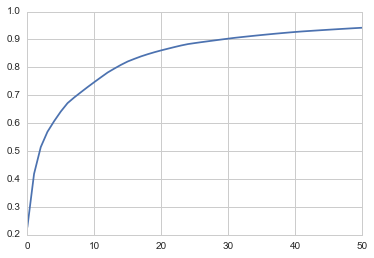

In [37]:
sns.set_style('whitegrid')
plt.plot(np.cumsum(user_contrib)/np.sum(user_contrib))
plt.xlim(0,50)

### Plotting Contributions Spatially

In [38]:
colors = sns.color_palette("Set1", 10)

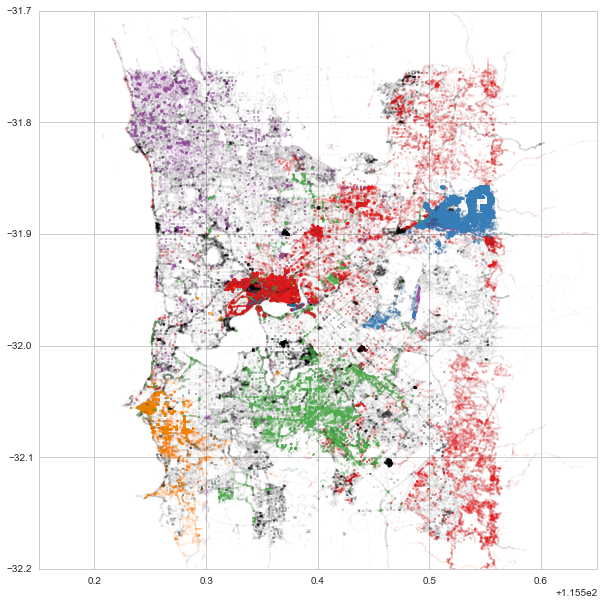

In [40]:
plt.figure(figsize=[10,10])

temp_df = node_df[~node_df.user.isin(user_contrib[:5].index)]
plt.scatter(temp_df.lon, temp_df.lat, s=0.1, alpha=0.2, color = 'k')

for i, usr in enumerate(user_contrib[:5].index):
#     print(usr)
    temp_df = node_df[node_df.user == usr]
    plt.scatter(temp_df.lon, temp_df.lat, s=0.1, alpha=0.4, color = colors[i])


# plt.legend()
plt.xlim(115.65,116.15)
plt.ylim(-32.2, -31.7)
plt.show()


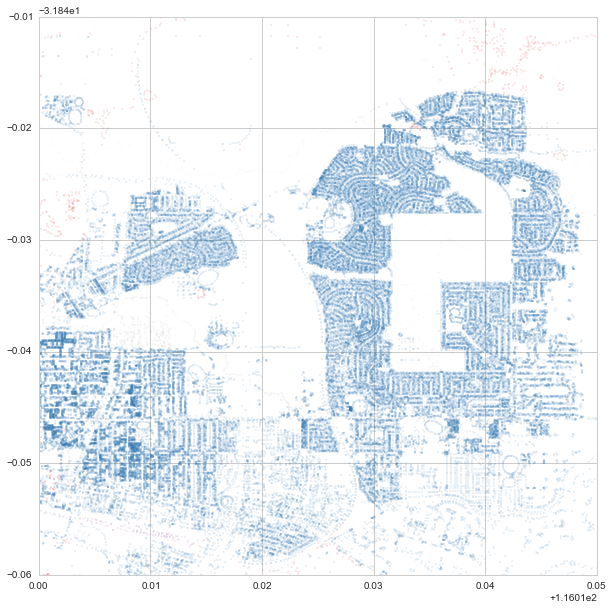

In [41]:
plt.figure(figsize=[10,10])

temp_df = node_df[~node_df.user.isin(user_contrib[:5].index)]
plt.scatter(temp_df.lon, temp_df.lat, s=0.1, alpha=0.2, color = 'k')

for i, usr in enumerate(user_contrib[:5].index):
#     print(usr)
    temp_df = node_df[node_df.user == usr]
    plt.scatter(temp_df.lon, temp_df.lat, s=0.1, alpha=1, color = colors[i])


# plt.legend()
plt.xlim(116.01,116.06)
plt.ylim(-31.9, -31.85)
plt.show()


### Plotting Contributions Temporally

In [42]:
node_df['decimal_date'] = node_df.time.apply(lambda x: x.year + x.month/12 + x.day/31)

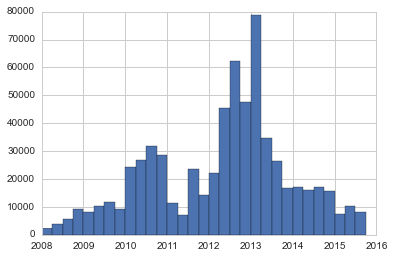

In [47]:
plt.hist(node_df.decimal_date, bins= np.arange(2008, 2016, 1/4))
plt.xticks(range(2008,2017), range(2008, 2017))
plt.show()

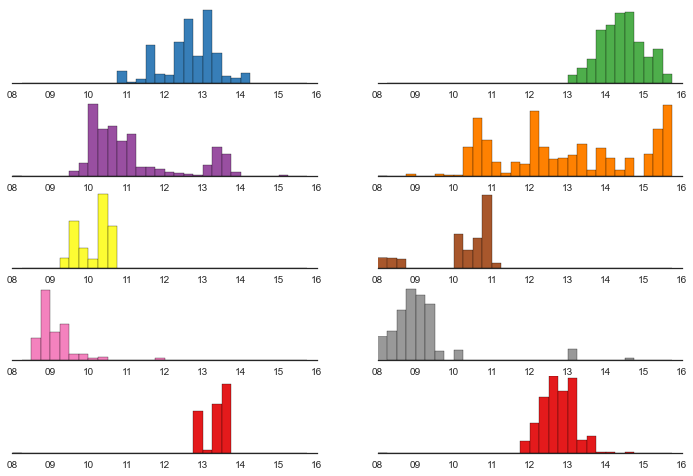

In [50]:
sns.set_style('white')
plt.figure(figsize=[12,8])

for i, usr in enumerate(user_contrib[:10].index):
    plt.subplot(5,2,i)
    temp_df = node_df[node_df.user == usr]
    plt.hist(temp_df.decimal_date.tolist(), bins= np.arange(2008, 2016, 1/4), color=colors[i])
    plt.xticks(range(2008,2017), [str(x)[-2:] for x in range(2008,2017)])
    plt.yticks([0],[''])
    sns.despine(left=True)
plt.show()


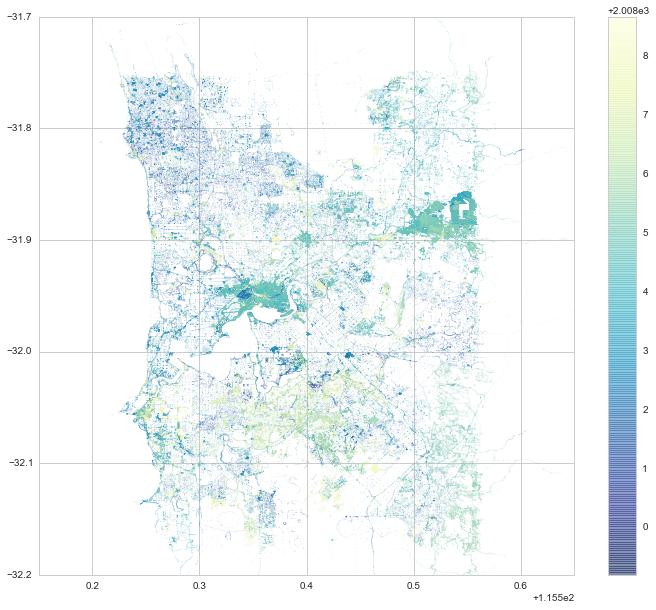

In [43]:
plt.figure(figsize=[12,10])
plt.scatter(node_df.lon, node_df.lat, c=node_df.decimal_date, s=0.2, alpha=0.5, cmap='YlGnBu_r', lw=0)
plt.colorbar()
plt.xlim(115.65,116.15)
plt.ylim(-32.2, -31.7)
plt.show()

### Unlucky 13

In [52]:
def top_10(key, num=10):
    cursor = osm.aggregate([
            {'$match': {key: {'$exists':1}}},
            {'$group': {'_id':'$'+key, 
                        'count':{'$sum':1}}},
            {'$sort' : {'count':-1}},
            {'$limit': num}
        ])
    return [i for i in cursor]

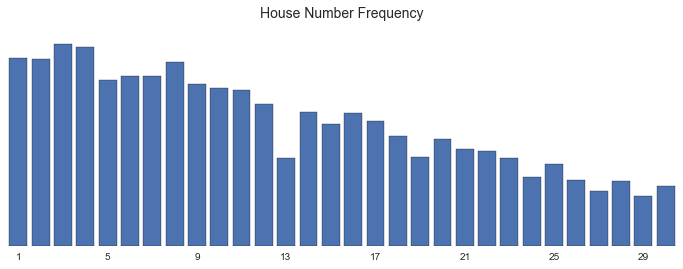

In [57]:
pop_numbers = top_10('address.housenumber', 200)
numdf = pd.DataFrame(pop_numbers)
def try_int(x):
    try:
        return int(x)
    except:
        return nan
numdf._id = numdf._id.apply(try_int)
numdf = numdf.dropna()

plt.figure(figsize=[12,4])
plt.bar(numdf._id-0.4, numdf['count'], width=0.8)
plt.xticks(range(1,31,4))
plt.yticks([])
plt.xlim(0.5,30.5)
plt.title('House Number Frequency', fontsize=14)
sns.despine(left=True, bottom=True)

### Other Observations

In [51]:
# available_keys = {}
# for i in osm.find():
#     for k,v in i.iteritems():
#         available_keys[k] = available_keys.get(k, 0) + 1
#         if isinstance(v, dict):
#             for m,n in v.iteritems():
#                 available_keys['{}.{}'.format(k,m)] = available_keys.get('{}.{}'.format(k,m), 0) + 1
# keys = pd.Series(available_keys)
# keys.sort(ascending=False)
# keys[:40]

In [53]:
top_10('amenity')

[{u'_id': u'parking', u'count': 1814},
 {u'_id': u'school', u'count': 395},
 {u'_id': u'restaurant', u'count': 236},
 {u'_id': u'fast_food', u'count': 235},
 {u'_id': u'bench', u'count': 230},
 {u'_id': u'cafe', u'count': 212},
 {u'_id': u'post_box', u'count': 205},
 {u'_id': u'place_of_worship', u'count': 183},
 {u'_id': u'drinking_water', u'count': 179},
 {u'_id': u'telephone', u'count': 151}]

In [54]:
top_10('address.city')

[{u'_id': u'Stratton', u'count': 1319},
 {u'_id': u'Jane Brook', u'count': 1022},
 {u'_id': u'Swan View', u'count': 716},
 {u'_id': u'Willetton', u'count': 652},
 {u'_id': u'West Perth', u'count': 638},
 {u'_id': u'Canning Vale', u'count': 566},
 {u'_id': u'Perth', u'count': 155},
 {u'_id': u'Bull Creek', u'count': 140},
 {u'_id': u'South Lake', u'count': 109},
 {u'_id': u'Bibra Lake', u'count': 87}]

## Conclusions